<a href="https://colab.research.google.com/github/Misdinar/GAsin-Sudoku/blob/main/Sudoku_FIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GASin SUDOKU**

Genetic Algoritms in SUDOKU

In [1]:
import numpy
import random
from functools import cmp_to_key
import matplotlib.pyplot as plt

In [2]:
random.seed()

### Class Sudoku

In [3]:
class Sudoku(object):
    """ 
    Class ini akan menjadi bentuk runtutan dari Implementasi GAs dalam memecahkan proble sudoku 9x9.
    Problem sudoku yang digunakan akan berupa kumpulan list urutan angka yang dapat dilihat pada board.

    un-comment untuk mencoba tipe selection/crossover yang ingin digunakan
    """

    def __init__(self):
        self.original = None
        return
    
    def load(self, board):
        '''
        Merubah list dari setiap list angka yang ada diboard menjadi array.
        hasil array tersebut akan disimpan sebagai artibut class Original
        Transforms a list of lists into a np array, which represents the Sudoku board, then saves it as class attibute.
        
        Input: List(board sudoku)
        Output: Tidak Ada
        '''
        values = numpy.array(board)
        self.original = Original(values)          
        return

        
    def solve(self):
        '''
        fungs ini akan menjadi urutan metode(selection, mutasi, dan crossover) 
        yang akan digunakan untuk memecahkan problem sudoku.
        Outputnya berupa generasi terakhir sebelum finalisasi generasi 
        dan list yang berisi semua nilai fitness.
        
        Input: Tidak ada
        Output: Tuple (int, list)
        '''
        history=[] # List untuk menyimpan nilai fitness
        candi = 1000  # konstanta dari jumlah kandidat(child) 
        elit = 5  # konstanta dari jumlah elit(parents) 
        gen = 1200  # konstanta dari jumlah generasi
        mutation_rate = 0.08
        crossover_rate = .8
        
        # Proses inisiasi populasi
        self.population = Population()
        self.population.trial(candi, self.original)
    
        # Untuk generasi diatas 10.000, Ketika patience mencapai 250,
        # maka pencarian akan diulang dari generasi yang terakhir.
        patience = 0
        for generation in range(0, gen):
        
            print("Generasi ke-%d" % generation)
            
            # Proses mencari nilai fitness.
            best_fitness = 0.0
            for c in range(0, candi):
                fitness = self.population.candidates[c].fitness
                if(fitness == 1):
                    print("Solusi tidak ditemukan %d!" % generation)
                    print(self.population.candidates[c].values)
                    return (generation,history )

                # Mengganti nilai fitnes dengan nilai yang lebih tinggi
                if(fitness > best_fitness):
                    best_fitness = fitness

            print("Best fitness: %f" % best_fitness)

            # Membuat populasi selanjutnya.
            next_population = []

            # Memilih elite dan disimpan untuk generasi selanjutnya.
            self.population.fitsort()
            elites = []
            for e in range(0, elit):
                elite = Individual()
                elite.values = numpy.copy(self.population.candidates[e].values)
                elites.append(elite)

            # Proses membuat generasi baru
            for nggr in range(elit, candi, 2):
                
                # Selection methods Roulette
                s = Roulette()

                '''
                # Selection methods Roulette
                s = Tournament()
                '''

                parent1 = s.compete(self.population.candidates)
                parent2 = s.compete(self.population.candidates)
                
                ## Cross-over 2-point.
                x = Crossover_Double()
                child1, child2 = x.cyclecrossover(parent1, parent2, crossover_rate)

                '''
                ## Cross-over 1-point.
                x = Crossover_Single()
                child1, child2 = x.cyclecrossover(parent1, parent2, crossover_rate)
                '''
                # Mutation
                if child1.fitness is None:
                    old_fitness = 0
                else:
                    old_fitness = child1.fitness
                success = child1.swap_mutate(mutation_rate, self.original)
                child1.update_fitness()


                if child2.fitness is None:
                    old_fitness = 0
                else:
                    old_fitness = child2.fitness
                success = child2.swap_mutate(mutation_rate, self.original)
                child2.update_fitness()

                
                # Menambahkan children ke dalam populasi yang baru.
                next_population.append(child1)
                next_population.append(child2)

            # menambahkan elites ke urutan populasi terakhir
            for e in range(0, elit):
                next_population.append(elites[e])
                
            # Memilih generasi selanjutnya.
            self.population.candidates = next_population
            self.population.update_fitness()
            

            # Memeriksa patience dan memastikan apakah nilai fitness masih berkembang
            self.population.fitsort()
            if(self.population.candidates[0].fitness != best_fitness):
                patience = 0
            else:
                patience += 1
            history.append(best_fitness)
            
            # Pencarian akan di ulang kembali jika 250 generasi telah berlalu 
            # dengan best_fitness tidak berkembang.
            if(patience >= 250):
                print("Populasi tidak mengalami perkembangan. Coba lagi!")
                self.population.trial(candi, self.original)
                patience = 0
                mutation_rate = 0.06
        
        print("Tidak ada Solusi untuk Problem Sudoku ini")
        return (None,history)

### Class Individual

Menggunakan Swap Mutation

In [4]:
class Individual(object):
    """ 
    Ini mewakili kemungkinan sebuah anggota suatu populasi.
    Ini memiliki atribut fitness dan nilai sebagai karakteristik solusi Sudoku.
    
    """
    def __init__(self):
        self.values = numpy.zeros((9, 9), dtype=int) #9x9 matrix nol
        self.fitness = None
        return

    def update_fitness(self):
        '''
        Metode ini memperbarui fitness ke Individu berdasarkan kedekatannya dengan solusi optimal.
        Nilai fitness Dicapai dengan mengevaluasi jumlah angka yang berbeda di masing-masing dari 9 kolom dan baris,
        kemudian menjumlahkan skornya

        '''
        
        row_count = numpy.zeros(9)
        column_count = numpy.zeros(9)
        block_count = numpy.zeros(9)
        row_sum = 0
        column_sum = 0
        block_sum = 0

        for i in range(0, 9):  # Untuk setiap baris
            for j in range(0, 9):  # Untuk setiap angka didalam baris tersebut
                row_count[self.values[i][j]-1] += 1  # Update list dengan kemunculan nomor tertentu
            row_sum += (1.0/len(set(row_count)))/9
            row_count = numpy.zeros(9) # reset row_count untuk baris berikutnya

        #sama seperti yang diatas, tapi untuk kolom
        for i in range(0, 9):
            for j in range(0, 9):
                column_count[self.values[j][i]-1] += 1 
            column_sum += (1.0 / len(set(column_count)))/9
            column_count = numpy.zeros(9)


        # Untuk setiap blok 3x3
        for i in range(0, 9, 3):
            for j in range(0, 9, 3):
                #menghitung nilai untuk setiap 3 kolom dalam satu baris
                block_count[self.values[i][j]-1] += 1
                block_count[self.values[i][j+1]-1] += 1
                block_count[self.values[i][j+2]-1] += 1
                
                block_count[self.values[i+1][j]-1] += 1
                block_count[self.values[i+1][j+1]-1] += 1
                block_count[self.values[i+1][j+2]-1] += 1
                
                block_count[self.values[i+2][j]-1] += 1
                block_count[self.values[i+2][j+1]-1] += 1
                block_count[self.values[i+2][j+2]-1] += 1

                block_sum += (1.0/len(set(block_count)))/9
                block_count = numpy.zeros(9)

        # Menghitung semua nilai fitness.
        if (int(row_sum) == 1 and int(column_sum) == 1 and int(block_sum) == 1):
            fitness = 1.0
        else: 
            fitness = row_sum * column_sum * block_sum
        
        self.fitness = fitness
        return
        
    def swap_mutate(self, mutation_rate, original):
        """ 
        Mutasi Swab. Sebuah baris acak dipilih untuk bermutasi, baris itu bertukar 2 kotak acak satu sama lain.
        Metode ini memastikan bahwa baris/kolom/blok yang dimodifikasi bukan dari tidak ada persegi yang tidak dapat diubah.
        Akhirnya mengembalikan Boolean yang menunjukkan mutasi berhasil atau tidak.
        
        Input:Float, Individual()
        Output: Boolean
        
        """

        r = random.uniform(0, 1)

        success = False
        if (r <= mutation_rate):  # Mutate.
            while(not success):
                row = random.randint(0, 8)
                   
                columns = random.sample([i for i in range(8)],2)
                from_column = columns[0]
                to_column = columns[1]
                
                
                # memerika jika ada 2 baris acak yang bisa diswap...
                if(original.values[row][from_column] == 0 and original.values[row][to_column] == 0):
                    # ...and that we are not causing a duplicate in the original blockas & columns.
                    if(not original.is_column_duplicate(to_column, self.values[row][from_column])
                       and not original.is_column_duplicate(from_column, self.values[row][to_column])
                       and not original.is_block_duplicate(row, to_column, self.values[row][from_column])
                       and not original.is_block_duplicate(row, from_column, self.values[row][to_column])):
                    
                        # Swap values.
                        temp = self.values[row][to_column]
                        self.values[row][to_column] = self.values[row][from_column]
                        self.values[row][from_column] = temp
                        success = True

        return success  

### Class Population

In [5]:
class Population(object):
    """ 
    Set kemungkinan Sudoku dalam sebuah generasi.
    A set of possible solutions to the Sudoku puzzle in the generation.
    """

    def __init__(self):
        self.candidates = []
        return

    def trial(self, candi, matrix):
        self.candidates = []
        
        # menentukan nilai yang bisa dimiliki sebuah blok.
        guidelines = Individual()
        guidelines.values = [[[] for j in range(0, 9)] for i in range(0, 9)]
        #The matrix became a 9x9 of [] spaces
        for row in range(0, 9):
            for column in range(0, 9):
                for value in range(1, 10):
                    if((matrix.values[row][column] == 0) and not (matrix.is_column_duplicate(column, value) 
                      or matrix.is_block_duplicate(row, column, value) or matrix.is_row_duplicate(row, value))):
                        # jika nilai tersedia
                        guidelines.values[row][column].append(value)
                    elif(matrix.values[row][column] != 0):
                        # memasukkan nilai yg diperoleh kedalam guidelines Given/known value from file.
                        guidelines.values[row][column].append(matrix.values[row][column])
                        break
        # Bagian di atas membuat list solusi yang memungkin untuk setiap kotak, 
        # menghapus duplikat dan membuat guidelines.

        # Calon populasi baru.       
        for p in range(0, candi):
            g = Individual()
            for i in range(0, 9): # baris baru untuk kandidat.
                row = numpy.zeros(9)
                
                # Memasukan nilai matrix ke column ke-j di baris ke-i.
                for j in range(0, 9):
                
                    # Jika nilai sudah digunakan, maka tidak perlu diganti
                    if(matrix.values[i][j] != 0):
                        row[j] = matrix.values[i][j]
                    # mengisi bagian yang kosong dengan 0.
                    elif(matrix.values[i][j] == 0):

                        row[j] = guidelines.values[i][j][random.randint(0, len(guidelines.values[i][j])-1)]

                # jika populasi masih salah, maka dilakukan kembali
                # dan memastikan bahwa tidak ada baris yang duplikat
                while(len(list(set(row))) != 9):
                    for j in range(0, 9):
                        if(matrix.values[i][j] == 0):
                            row[j] = guidelines.values[i][j][random.randint(0, len(guidelines.values[i][j])-1)]

                g.values[i] = row #Reminder: g adalah Individual yang memiliki nilai
            self.candidates.append(g)
        # Bagian diatas menghasilkan list baris dengan 9 angka random

        # Menghitng fitness dari semua kandida dalam populasi.
        self.update_fitness()
        return
        
    def update_fitness(self):
        """ Update nilai fitness setiap kandidat/individual. 
        Input: List
        Output: Float
    
        """
        for candidate in self.candidates:
            candidate.update_fitness()
        return
        
    def fitsort(self):
        """ Mengurutkan populasi berdasarkan nilai fitness. """
        self.candidates.sort(key=cmp_to_key(self.mycmp))
        return

    def mycmp(self, x, y):
        """ Fungsi Sorting. """
        if(x.fitness < y.fitness):
            return 1
        elif(x.fitness == y.fitness):
            return 0
        else:
            return -1

### Class Original
memeriksa array yang diberikan memenuhi syarat sudoku

In [8]:
class Original(Individual):
    """ Array problem Sudoku di-load """

    def __init__(self, values):
        self.values = values
        return
        
    def is_row_duplicate(self, row, value):
        """ Memeriksa apakah dalam baris tersebut ada
            nilai yang sama"""
        for column in range(0, 9):
            if(self.values[row][column] == value):
                return True
        return False

    def is_column_duplicate(self, column, value):
        """ Memeriksa apakah dalam kolom tersebut ada
            nilai yang sama"""
        for row in range(0, 9):
            if(self.values[row][column] == value):
                return True
        return False

    def is_block_duplicate(self, row, column, value):
        """ Memeriksa apakah dalam kotak 3x3 ada nilai yang sama"""
        i = 3*(int(row/3))
        j = 3*(int(column/3))

        if((self.values[i][j] == value)
           or (self.values[i][j+1] == value)
           or (self.values[i][j+2] == value)
           or (self.values[i+1][j] == value)
           or (self.values[i+1][j+1] == value)
           or (self.values[i+1][j+2] == value)
           or (self.values[i+2][j] == value)
           or (self.values[i+2][j+1] == value)
           or (self.values[i+2][j+2] == value)):
            return True
        else:
            return False

### Class Selection Tournament

In [16]:
class Tournament(object):
    '''
    Seleksi Turnamen GA, memilih 2 parents secara acak untuk bersaing memiliki keturunan nanti.
    '''

    def __init__(self):
        return
        
    def compete(self, individuals):
        """ Memilih 2 parents secara acak untuk bersaing agar memiliki keturunan.
        selection rate akan memilih pemenang dan
        memberikan keuntungan yang buruk bagi pemenang yang paling cocok.
        
        Input: Individual()
        Output: Individual()
        """
        
    # Memilih individu berdasarkan tournament size
        tournament = random.sample(individuals, 2)
    
        c1 = tournament[0]
        c2 = tournament[1]
        f1 = c1.fitness
        f2 = c2.fitness

        # mencari yang paling fit dan lemah.
        if(f1 > f2):
            fittest = c1
            weakest = c2
        else:
            fittest = c2
            weakest = c1

        selection_rate = 0.95
        r = random.uniform(0, 1)

        if(r < selection_rate):
            return fittest
        else:
            return weakest

### Class Selection Roulette

In [17]:
class Roulette(object):
    '''
    GA Roulette Selection, menjumlahkan total fitness dair populasi 
    dan menghasilkan angka acak di dalamnya untuk memilih parent.
    Tentu saja itu memberikan lebih banyak kemungkinan seleksi 
    untuk parents dengan kebugaran yang lebih tinggi. 
    '''
    def __init__(self):
        return
    
    def compete(self, population):
        '''       
        Input: Population()
        Output: Individual()
        '''
        total_fitness = sum([i.fitness for i in population])  
    # Memperoleh 'posisi' dalam roulette wheel
        spin = random.uniform(0, total_fitness)
        position = 0
        # Mencari individu yang berada di posisi spin tersebut
        for individual in population:
            position += individual.fitness
            if position > spin:
                return individual

### Class Crossover Double

In [11]:
class Crossover_Double(object):
    """ 
    Ini adalah Crossover double untuk Matriks,
    baris yang dipilih akan diperlakukan dengan siklus Crossover
    untuk me-return children dari gen campuran.
    """
    
    def __init__(self):
        return
    
    def cyclecrossover(self, parent1, parent2, crossover_rate):
        """ 
        Sebuah titik acak dalam Matriks dipilih untuk membagi baris 
        menjadi 2 bagian, yaitu baris yang akan diubah dan yang tidak.
        Fungsi crossover_rows dihunakan untuk 
        menyilangkan dan me-return dua anak sebagai Individu
        
        Input: Individual(), Individual(), Float
        Output: Individual(), Individual()
        """

        # melakuan crossover
    
        child1 = Individual()
        child2 = Individual()
        
        #  membuat copy dari gen parent.
        child1.values = numpy.copy(parent1.values)
        child2.values = numpy.copy(parent2.values)

        r = random.uniform(0, 1.1)
        while(r > 1):  # jika ada nilai >1, maka dilakukan random.uniform lagi
            r = random.uniform(0, 1.1)
            
        
        if (r < crossover_rate):
            
            points = random.sample([i for i in range(10)],2)
            crossover_point2 = max(points)   
            crossover_point1 = min(points)
                
                #Melakukan crossover sebuah baris dengan baris yang dipilih
            for i in range(crossover_point1, crossover_point2):
                child1.values[i], child2.values[i] = self.crossover_rows(child1.values[i], child2.values[i])

        #baris child1 akan digantikan dengan childrennya
        return child1, child2

    def crossover_rows(self, row1, row2): 
        '''
        Siklus Crossover pada baris yang dipilih pada tahap sebelumnya.
        Ini me-return baris yang diubah menjadi children yang dipilih.
        Input: Np.array, Np.array
        Output: List, List
        '''
        
        offspring1 = [None] * len(row1)
        offspring2 = [None] * len(row2)

        while None in offspring1:
            index = offspring1.index(None)

            if index != 0:
                row2,row2 = row2,row2
            val1 = row1[index]
            val2 = row2[index]

            while val1 != val2:
                offspring1[index] = row1[index]
                offspring2[index] = row2[index]
                val2 = row2[index]
                row1_temp = row1.tolist()
                
                index = row1_temp.index(val2)
            offspring1[index] = row1[index]
            offspring2[index] = row2[index]
        
        return offspring1, offspring2
    

### Class Crossover Single

In [12]:
class Crossover_Single(object):
    """ 
    Ini adalah Crossover single untuk Matriks,
    baris yang dipilih akan diperlakukan dengan siklus Crossover
    untuk me-return children dari gen campuran
    """

    def __init__(self):
        return
    
    def cyclecrossover(self, parent1, parent2, crossover_rate):
    
        child1 = Individual()
        child2 = Individual()
        
        child1.values = numpy.copy(parent1.values)
        child2.values = numpy.copy(parent2.values)

        r = random.uniform(0, 1)

        if (r < crossover_rate):
            
            points = random.sample([i for i in range(8)],1)
                
                #Melakukan crossover sebuah baris dengan baris yang dipilih
            for i in range(points[0], 9):
                child1.values[i], child2.values[i] = self.crossover_rows(child1.values[i], child2.values[i])

        return child1, child2

    def crossover_rows(self, row1, row2): 

        offspring1 = [None] * len(row1)
        offspring2 = [None] * len(row2)

        while None in offspring1:
            index = offspring1.index(None)

            if index != 0:
                row2,row2 = row2,row2
            val1 = row1[index]
            val2 = row2[index]

            while val1 != val2:
                offspring1[index] = row1[index]
                offspring2[index] = row2[index]
                val2 = row2[index]
                row1_temp = row1.tolist() #Dirubah ke list agar dapat digunakan oleh atribut index
                index = row1_temp.index(val2)
            offspring1[index] = row1[index]
            offspring2[index] = row2[index]
        
        return offspring1, offspring2
    

# Problem Sudoku

Berisi beberapa problem sudoku

In [13]:
board = [
    [4,0,0,0,9,1,0,0,0],
    [0,0,9,0,0,7,4,2,5],
    [0,5,8,3,4,0,1,9,0],
    [6,9,1,0,0,0,0,0,0],
    [0,0,3,9,6,4,7,0,0],
    [0,0,0,0,0,0,9,6,3],
    [0,8,7,0,2,6,5,3,0],
    [3,1,5,8,0,0,6,0,0],
    [0,0,0,1,5,0,0,0,9]
]

Generasi ke-0
Best fitness: 0.851852
Generasi ke-1
Best fitness: 0.851852
Generasi ke-2
Solusi tidak ditemukan 2!
[[4 6 2 5 9 1 3 8 7]
 [1 3 9 6 8 7 4 2 5]
 [7 5 8 3 4 2 1 9 6]
 [6 9 1 7 3 8 2 5 4]
 [5 2 3 9 6 4 7 1 8]
 [8 7 4 2 1 5 9 6 3]
 [9 8 7 4 2 6 5 3 1]
 [3 1 5 8 7 9 6 4 2]
 [2 4 6 1 5 3 8 7 9]]
Generasi ke-0
Best fitness: 0.851852
Generasi ke-1
Best fitness: 0.851852
Generasi ke-2
Best fitness: 0.851852
Generasi ke-3
Best fitness: 0.851852
Generasi ke-4
Solusi tidak ditemukan 4!
[[4 6 2 5 9 1 3 8 7]
 [1 3 9 6 8 7 4 2 5]
 [7 5 8 3 4 2 1 9 6]
 [6 9 1 7 3 8 2 5 4]
 [5 2 3 9 6 4 7 1 8]
 [8 7 4 2 1 5 9 6 3]
 [9 8 7 4 2 6 5 3 1]
 [3 1 5 8 7 9 6 4 2]
 [2 4 6 1 5 3 8 7 9]]
Generasi ke-0
Best fitness: 0.851852
Generasi ke-1
Best fitness: 0.851852
Generasi ke-2
Best fitness: 0.851852
Generasi ke-3
Solusi tidak ditemukan 3!
[[4 6 2 5 9 1 3 8 7]
 [1 3 9 6 8 7 4 2 5]
 [7 5 8 3 4 2 1 9 6]
 [6 9 1 7 3 8 2 5 4]
 [5 2 3 9 6 4 7 1 8]
 [8 7 4 2 1 5 9 6 3]
 [9 8 7 4 2 6 5 3 1]
 [3 1 5 8 7 9 6 4 2]

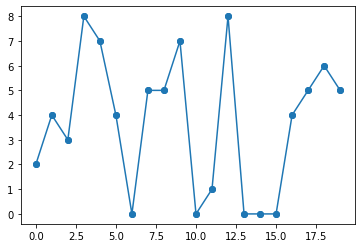

In [14]:
fit_hist = []
gen_hist = []
for i in range(20):
    s = Sudoku()
    s.load(board)
    solution = s.solve()
    fit_hist.append(solution[1])
    gen_hist.append(solution[0])
    
plt.scatter([i for i in range(len(gen_hist))],gen_hist)
plt.plot([i for i in range(len(gen_hist))],gen_hist, '-o')

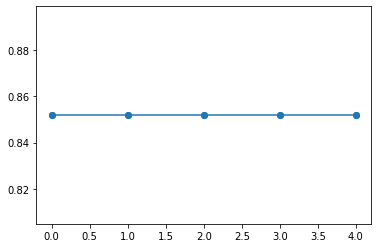

In [15]:
history = solution[1]
plt.scatter([i for i in range(len(history))],history)
plt.plot([i for i in range(len(history))],history, '-o')